### ДЗ №2


Файл titanicdf.csv, задачи:


1. Предобработать данные (пропуски, замена текста, дубликаты и т.д)
2. Использовать для классификации sklearn.ensemble.RandomForestClassifier
3. Подобрать лучшие гиперпараметры (n_estimators, criterion, max_depth)
4. Провести кроссвалидацию модели
5. Оценить метрики бинарной классификации (Precision, recall, f1)
6. Построить ROC-кривую для оценки качества классификатора

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

In [2]:
df = pd.read_csv('titanicdf.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 1. Предобработать данные

In [4]:
# Заменяем значения столбца Sex на числовые (0 - female, 1 - male)
df.loc[df.Sex == 'female', 'Sex'] = 0
df.loc[df.Sex == 'male', 'Sex'] = 1
df.loc[:, 'Sex'] = df.Sex.astype({'Sex': np.int64})

In [5]:
# Заменяем значения столбца Embarked на числовые: S - на 0, C - на 1, Q - на 2
df.Embarked = df.Embarked.fillna('S')
df.loc[df.Embarked == 'S', 'Embarked'] = 0
df.loc[df.Embarked == 'C', 'Embarked'] = 1
df.loc[df.Embarked == 'Q', 'Embarked'] = 2
df.loc[:, 'Embarked'] = df.Embarked.astype({'Embarked': np.int64})

In [6]:
# Устанавливаем для пропусков в столбце 'Age' медианные значения
# по группам в зависимости от 'Sex' и 'Pclass'
for i in df.Sex.unique():
    for j in df.Pclass.unique():
        df.loc[(df.Age.isna()) & (df.Sex == i) & (df.Pclass == j), 'Age'] =\
        df[(~df.Age.isna()) & (df.Sex == i) & (df.Pclass == j)]['Age'].median()

## 2. Использовать для классификации sklearn.ensemble.RandomForestClassifier

In [7]:
clf = RandomForestClassifier()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1),
                                                    df['Survived'], 
                                                    test_size=0.35,
                                                    random_state=1703
                                                    )

In [9]:
model = clf.fit(X_train, y_train)

In [10]:
pred = model.predict(X_test)

In [11]:
# df['Predicted_survival'] = pred

In [12]:
# df[df.Survived != df.Predicted_survival][['Survived', 'Predicted_survival']]

In [13]:
print('Accuracy:', accuracy_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.8205128205128205
Precision: 0.7549019607843137
Recall: 0.7129629629629629
F1: 0.7333333333333334


## 3. Подобрать лучшие гиперпараметры (n_estimators, criterion, max_depth)

In [14]:
test_params = []
# x = df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
# y = df['Survived']
for i in range (10, 131, 10):
    for j in range (1, 5):
        for k in ['gini', 'entropy']:
        # print("--------", deep, "--------", leaf)
            clf = RandomForestClassifier(n_estimators=i, max_depth=j, criterion=k)
            model = clf.fit(X_train, y_train)
            pred = model.predict(X_test)
            test_params.append([i, j, k, f1_score(y_test, pred), recall_score(y_test, pred)])

In [15]:
test_params = pd.DataFrame(test_params, columns=['n_estimators', 'max_depth', 'criterion', 'f1_score', 'recall_score'])
# test_params.columns = ['n_estimators', 'max_depth', 'criterion', 'f1_score', 'recall_score']

In [16]:
test_params.sort_values(by='f1_score', ascending=False).head(5)

,n_estimators,max_depth,criterion,f1_score,recall_score
6,10,4,gini,0.761421,0.694444
20,30,3,gini,0.760000,0.703704
69,90,3,entropy,0.758974,0.685185
26,40,2,gini,0.757576,0.694444
76,100,3,gini,0.757576,0.694444


### Модель с подобранными параметрами

In [17]:
model_2 = RandomForestClassifier(n_estimators=70, criterion='gini', max_depth=3)
model_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=70)

In [18]:
pred_2 = model_2.predict(X_test)

## 4. Провести кроссвалидацию модели

In [19]:
cv = ShuffleSplit(n_splits=10, test_size=0.35, random_state=0)
scores = cross_val_score(model_2, X_train, y_train, cv=cv, scoring='f1')

In [20]:
scores.mean()

0.7347476330355229

In [21]:
scores

array([0.76712329, 0.70588235, 0.74820144, 0.67924528, 0.72727273,
       0.76      , 0.75675676, 0.66666667, 0.76595745, 0.77037037])

## 5. Оценить метрики бинарной классификации (Precision, recall, f1)
Модель с подобранными параметрами

In [22]:
# print('Accuracy:', accuracy_score(y_test, pred_2))
print('Precision:', precision_score(y_test, pred_2))
print('Recall:', recall_score(y_test, pred_2))
print('F1:', f1_score(y_test, pred_2))

Precision: 0.7916666666666666
Recall: 0.7037037037037037
F1: 0.7450980392156864


## 6. Построить ROC-кривую для оценки качества классификатора

In [23]:
pred_proba = model.predict_proba(X_test)[:,1]

In [24]:
fpr, tpr, treshold = roc_curve(y_test, pred_proba)
tree_auc = roc_auc_score(y_test, pred_proba)
print(f'RandomForestClassifier: ROC AUC={round(tree_auc,2)}')

RandomForestClassifier: ROC AUC=0.89


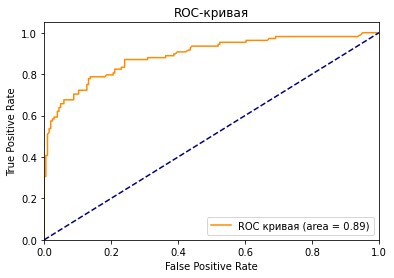

In [25]:
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr,  color='darkorange',
         label=f'ROC кривая (area = {round(roc_auc, 2)})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right") 
plt.show()